In [120]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pandas as pd
from pyspark.sql import DataFrame, Column
import skops.io as skio
from shap import TreeExplainer
from shap.plots import waterfall
import numpy as np
import rpy2



In [2]:
spark = SparkSession.builder.appName("example").getOrCreate()

25/01/23 15:53:22 WARN Utils: Your hostname, C02YN2L7JHD2 resolves to a loopback address: 127.0.0.1; using 172.23.49.141 instead (on interface en0)
25/01/23 15:53:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/23 15:53:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

# From gs://open-targets-pre-data-releases/24.12-uo_test-3/input/benchmarks_l2g_fm0_v5.1_best_cv_locus_to_gene_model_classifier.skops
model_path = "./data/benchmarks_l2g_fm0_v5.1_best_cv_locus_to_gene_model_classifier.skops"
model = skio.load(model_path, trusted=skio.get_untrusted_types(file=model_path))



/Users/ochoa/Projects/l2g_widget_poc/.venv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DummyClassifier from version 1.5.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/ochoa/Projects/l2g_widget_poc/.venv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/ochoa/Projects/l2g_widget_poc/.venv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle es

In [87]:
features_list = [
            # max CLPP for each (study, locus, gene) aggregating over a specific qtl type
            "eQtlColocClppMaximum",
            "pQtlColocClppMaximum",
            "sQtlColocClppMaximum",
            # max H4 for each (study, locus, gene) aggregating over a specific qtl type
            "eQtlColocH4Maximum",
            "pQtlColocH4Maximum",
            "sQtlColocH4Maximum",
            # max CLPP for each (study, locus, gene) aggregating over a specific qtl type and in relation with the mean in the vicinity
            "eQtlColocClppMaximumNeighbourhood",
            "pQtlColocClppMaximumNeighbourhood",
            "sQtlColocClppMaximumNeighbourhood",
            # max H4 for each (study, locus, gene) aggregating over a specific qtl type and in relation with the mean in the vicinity
            "eQtlColocH4MaximumNeighbourhood",
            "pQtlColocH4MaximumNeighbourhood",
            "sQtlColocH4MaximumNeighbourhood",
            # distance to gene footprint
            "distanceSentinelFootprint",
            "distanceSentinelFootprintNeighbourhood",
            "distanceFootprintMean",
            "distanceFootprintMeanNeighbourhood",
            # distance to gene tss
            "distanceTssMean",
            "distanceTssMeanNeighbourhood",
            "distanceSentinelTss",
            "distanceSentinelTssNeighbourhood",
            # vep
            "vepMaximum",
            "vepMaximumNeighbourhood",
            "vepMean",
            "vepMeanNeighbourhood",
            # other
            "geneCount500kb",
            "proteinGeneCount500kb",
            "credibleSetConfidence",
        ]

# From gs://open-targets-pre-data-releases/24.12-uo_test-3/output/genetics/parquet/l2g_feature_matrix
fm = spark.read.parquet("data/l2g_feature_matrix").select("studyLocusId", "geneId", *features_list)
fm_pd = fm.limit(100_000).toPandas().drop(["studyLocusId", "geneId"], axis=1)
explainer = TreeExplainer(model, data=fm_pd, model_output="probability")


In [88]:
predictions = model.predict_proba(fm_pd.values)
np.mean(predictions[:,1])

np.float64(0.3271579227608556)

In [98]:
subset = fm.filter((f.col("studyLocusId") == "2089b267ff0a27715af4b75d81abd834")).filter(f.col("geneId").isin(["ENSG00000112514", "ENSG00000112511", "ENSG00000197283"]))
subset_pdf = subset.toPandas()

shap_values = explainer(subset_pdf.drop(["studyLocusId", "geneId"], axis=1))
subset_pdf
# shap_values
# shap_values = explainer.shap_values(subset_pdf.drop(["studyLocusId", "geneId"], axis=1))

,studyLocusId,geneId,eQtlColocClppMaximum,pQtlColocClppMaximum,sQtlColocClppMaximum,eQtlColocH4Maximum,pQtlColocH4Maximum,sQtlColocH4Maximum,eQtlColocClppMaximumNeighbourhood,pQtlColocClppMaximumNeighbourhood,...,distanceTssMeanNeighbourhood,distanceSentinelTss,distanceSentinelTssNeighbourhood,vepMaximum,vepMaximumNeighbourhood,vepMean,vepMeanNeighbourhood,geneCount500kb,proteinGeneCount500kb,credibleSetConfidence
0,2089b267ff0a27715af4b75d81abd834,ENSG00000112511,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.999344,0.999129,0.999344,0.00,0.0,0.000000,0.0,55.0,22.0,0.75
1,2089b267ff0a27715af4b75d81abd834,ENSG00000112514,0.205341,0.0,0.0,0.996388,0.0,0.0,1.0,0.0,...,1.000000,0.999785,1.000000,0.66,1.0,0.659996,1.0,55.0,22.0,0.75
2,2089b267ff0a27715af4b75d81abd834,ENSG00000197283,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.999700,0.999485,0.999700,0.00,0.0,0.000000,0.0,55.0,22.0,0.75


In [206]:
cs_predictions = model.predict_proba(subset_pdf.drop(["studyLocusId", "geneId"], axis=1).values)[:,1]
cs_predictions

array([0.08921847, 0.63296628, 0.07449055])

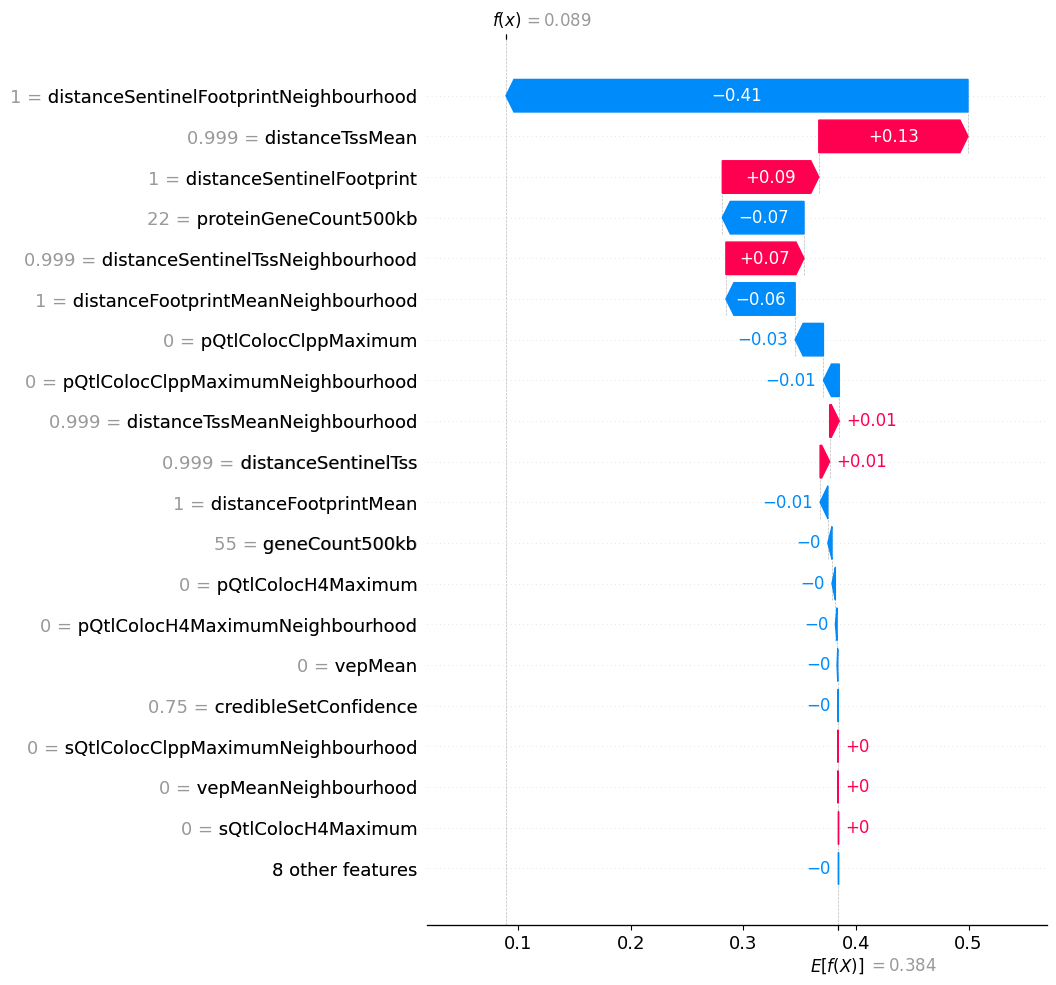

In [101]:
waterfall(shap_values[0], max_display=20)

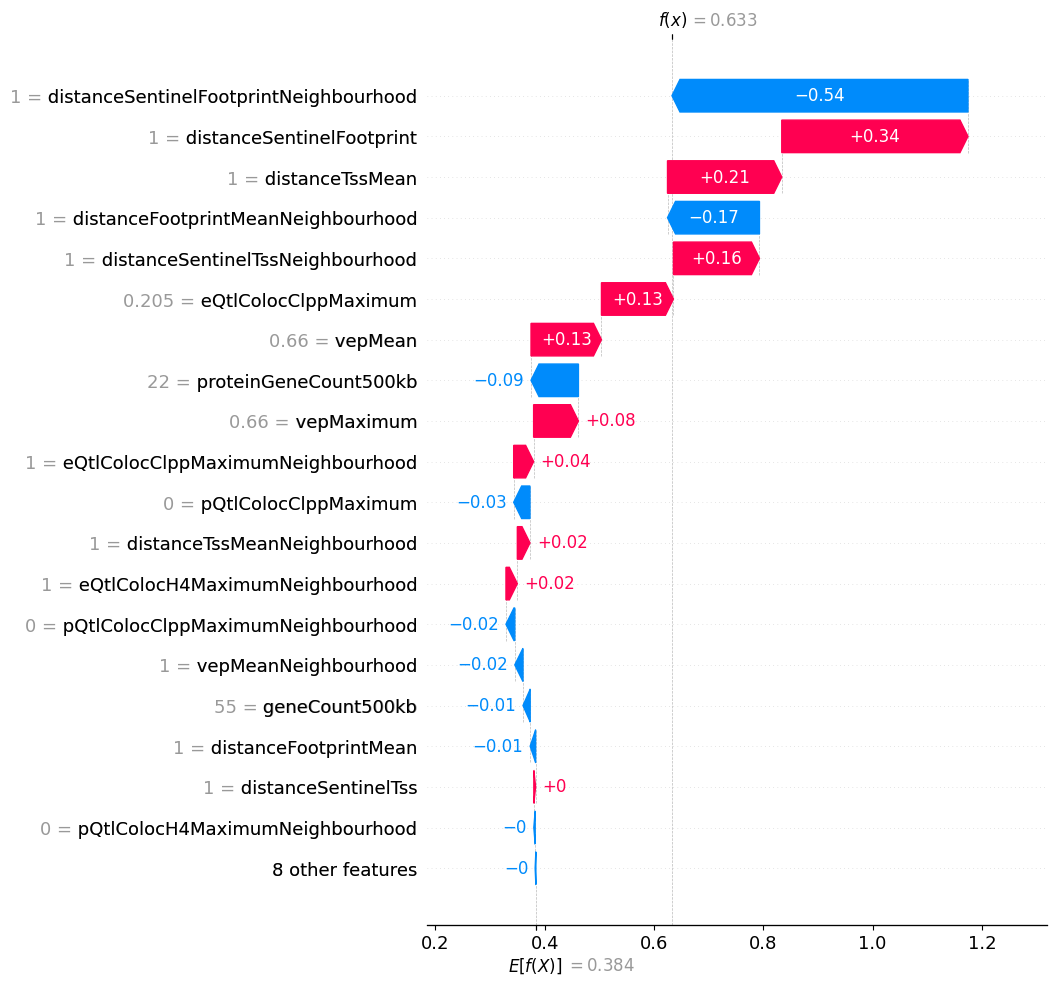

In [102]:
waterfall(shap_values[1], max_display=20)

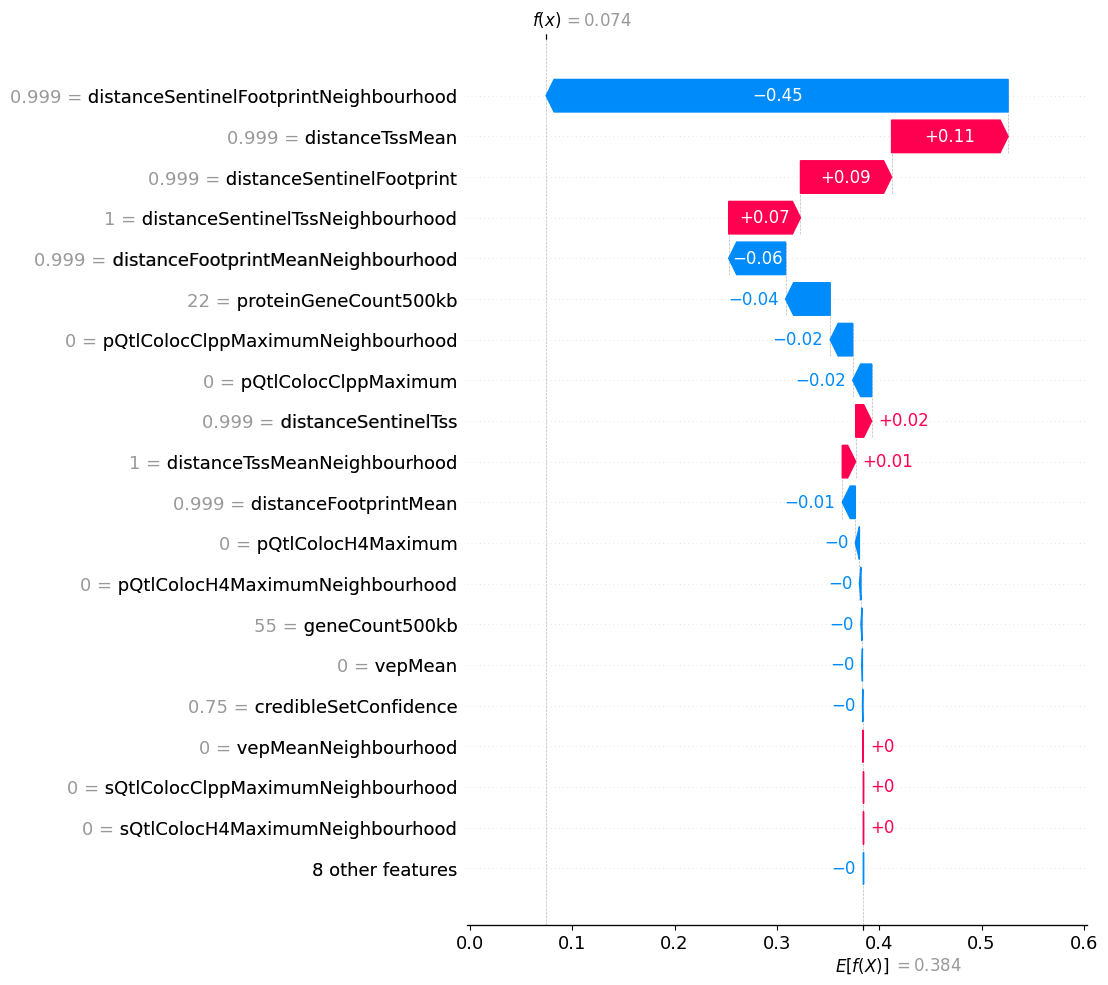

In [103]:
waterfall(shap_values[2], max_display=20)

In [95]:
y = -4.594
p = np.exp(np.sum(y))/(1.0+np.exp(np.sum(y)))
p


np.float64(0.010011092601978593)

In [114]:
# List of all feature names
shap_values.feature_names

# List of arrays with shapley values for each feature
shap_values.values

# List of base values
# E.g. array([-4.59435863, -4.59435863])
shap_values.base_values

# List of arrays with feature values
shap_values.data



array([0.38398235, 0.38398235, 0.38398235])

array(['ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112511', 'ENSG00000112511', 'ENSG00000112511',
       'ENSG00000112514', 'ENSG00000112514', 'ENSG00000112514',
       'ENSG00000112514', 'ENSG00000112514', 'ENSG00000112514',
       'ENSG00000112514', 'ENSG00000112514', 'ENSG00000112514',
       'ENSG00000112514', 'ENSG00000112514', 'ENSG00000112514',
       'ENSG00000112514', 'ENSG00000112514', 'ENSG00000112514',
       'ENSG00000112514', 'ENSG00000112514', 'ENSG00000112514',
       'ENSG00000112514', 'ENSG000001125

In [294]:
# Create dataframe in pandas with 4 columns: feature name, feature value, shapley value, base value
# It will create an exploded dataframe with one row per feature, per sample
shap_values_df_pd = pd.DataFrame(
    {
        "geneId": np.repeat(np.array(["PHF1", "CUTA", "SYNGAP1"]), len(shap_values.feature_names)),
        "feature": np.tile(shap_values.feature_names, len(shap_values.base_values)),
        "feature_value": np.concatenate(shap_values.data),
        "shapley_value": np.concatenate(shap_values.values),
        "base_value": np.repeat(shap_values.base_values, len(shap_values.feature_names)),
        "L2G": np.repeat(cs_predictions, len(shap_values.feature_names)),
    }
)
shap_values_df_pd

,geneId,feature,feature_value,shapley_value,base_value,L2G
0,PHF1,eQtlColocClppMaximum,0.00,0.000000,0.383982,0.089218
1,PHF1,pQtlColocClppMaximum,0.00,-0.025113,0.383982,0.089218
2,PHF1,sQtlColocClppMaximum,0.00,0.000000,0.383982,0.089218
3,PHF1,eQtlColocH4Maximum,0.00,0.000000,0.383982,0.089218
4,PHF1,pQtlColocH4Maximum,0.00,-0.003001,0.383982,0.089218
...,...,...,...,...,...,...
76,SYNGAP1,vepMean,0.00,-0.000445,0.383982,0.074491
77,SYNGAP1,vepMeanNeighbourhood,0.00,0.000013,0.383982,0.074491
78,SYNGAP1,geneCount500kb,55.00,-0.001009,0.383982,0.074491
79,SYNGAP1,proteinGeneCount500kb,22.00,-0.043603,0.383982,0.074491


In [295]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [296]:
%%R
packages <- c("ggplot2", "dplyr", "forcats", "RColorBrewer", "stringr", "tidyr")
for (package in packages) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package, repos = "http://cran.us.r-project.org")
  }
  library(package, character.only = TRUE)
}

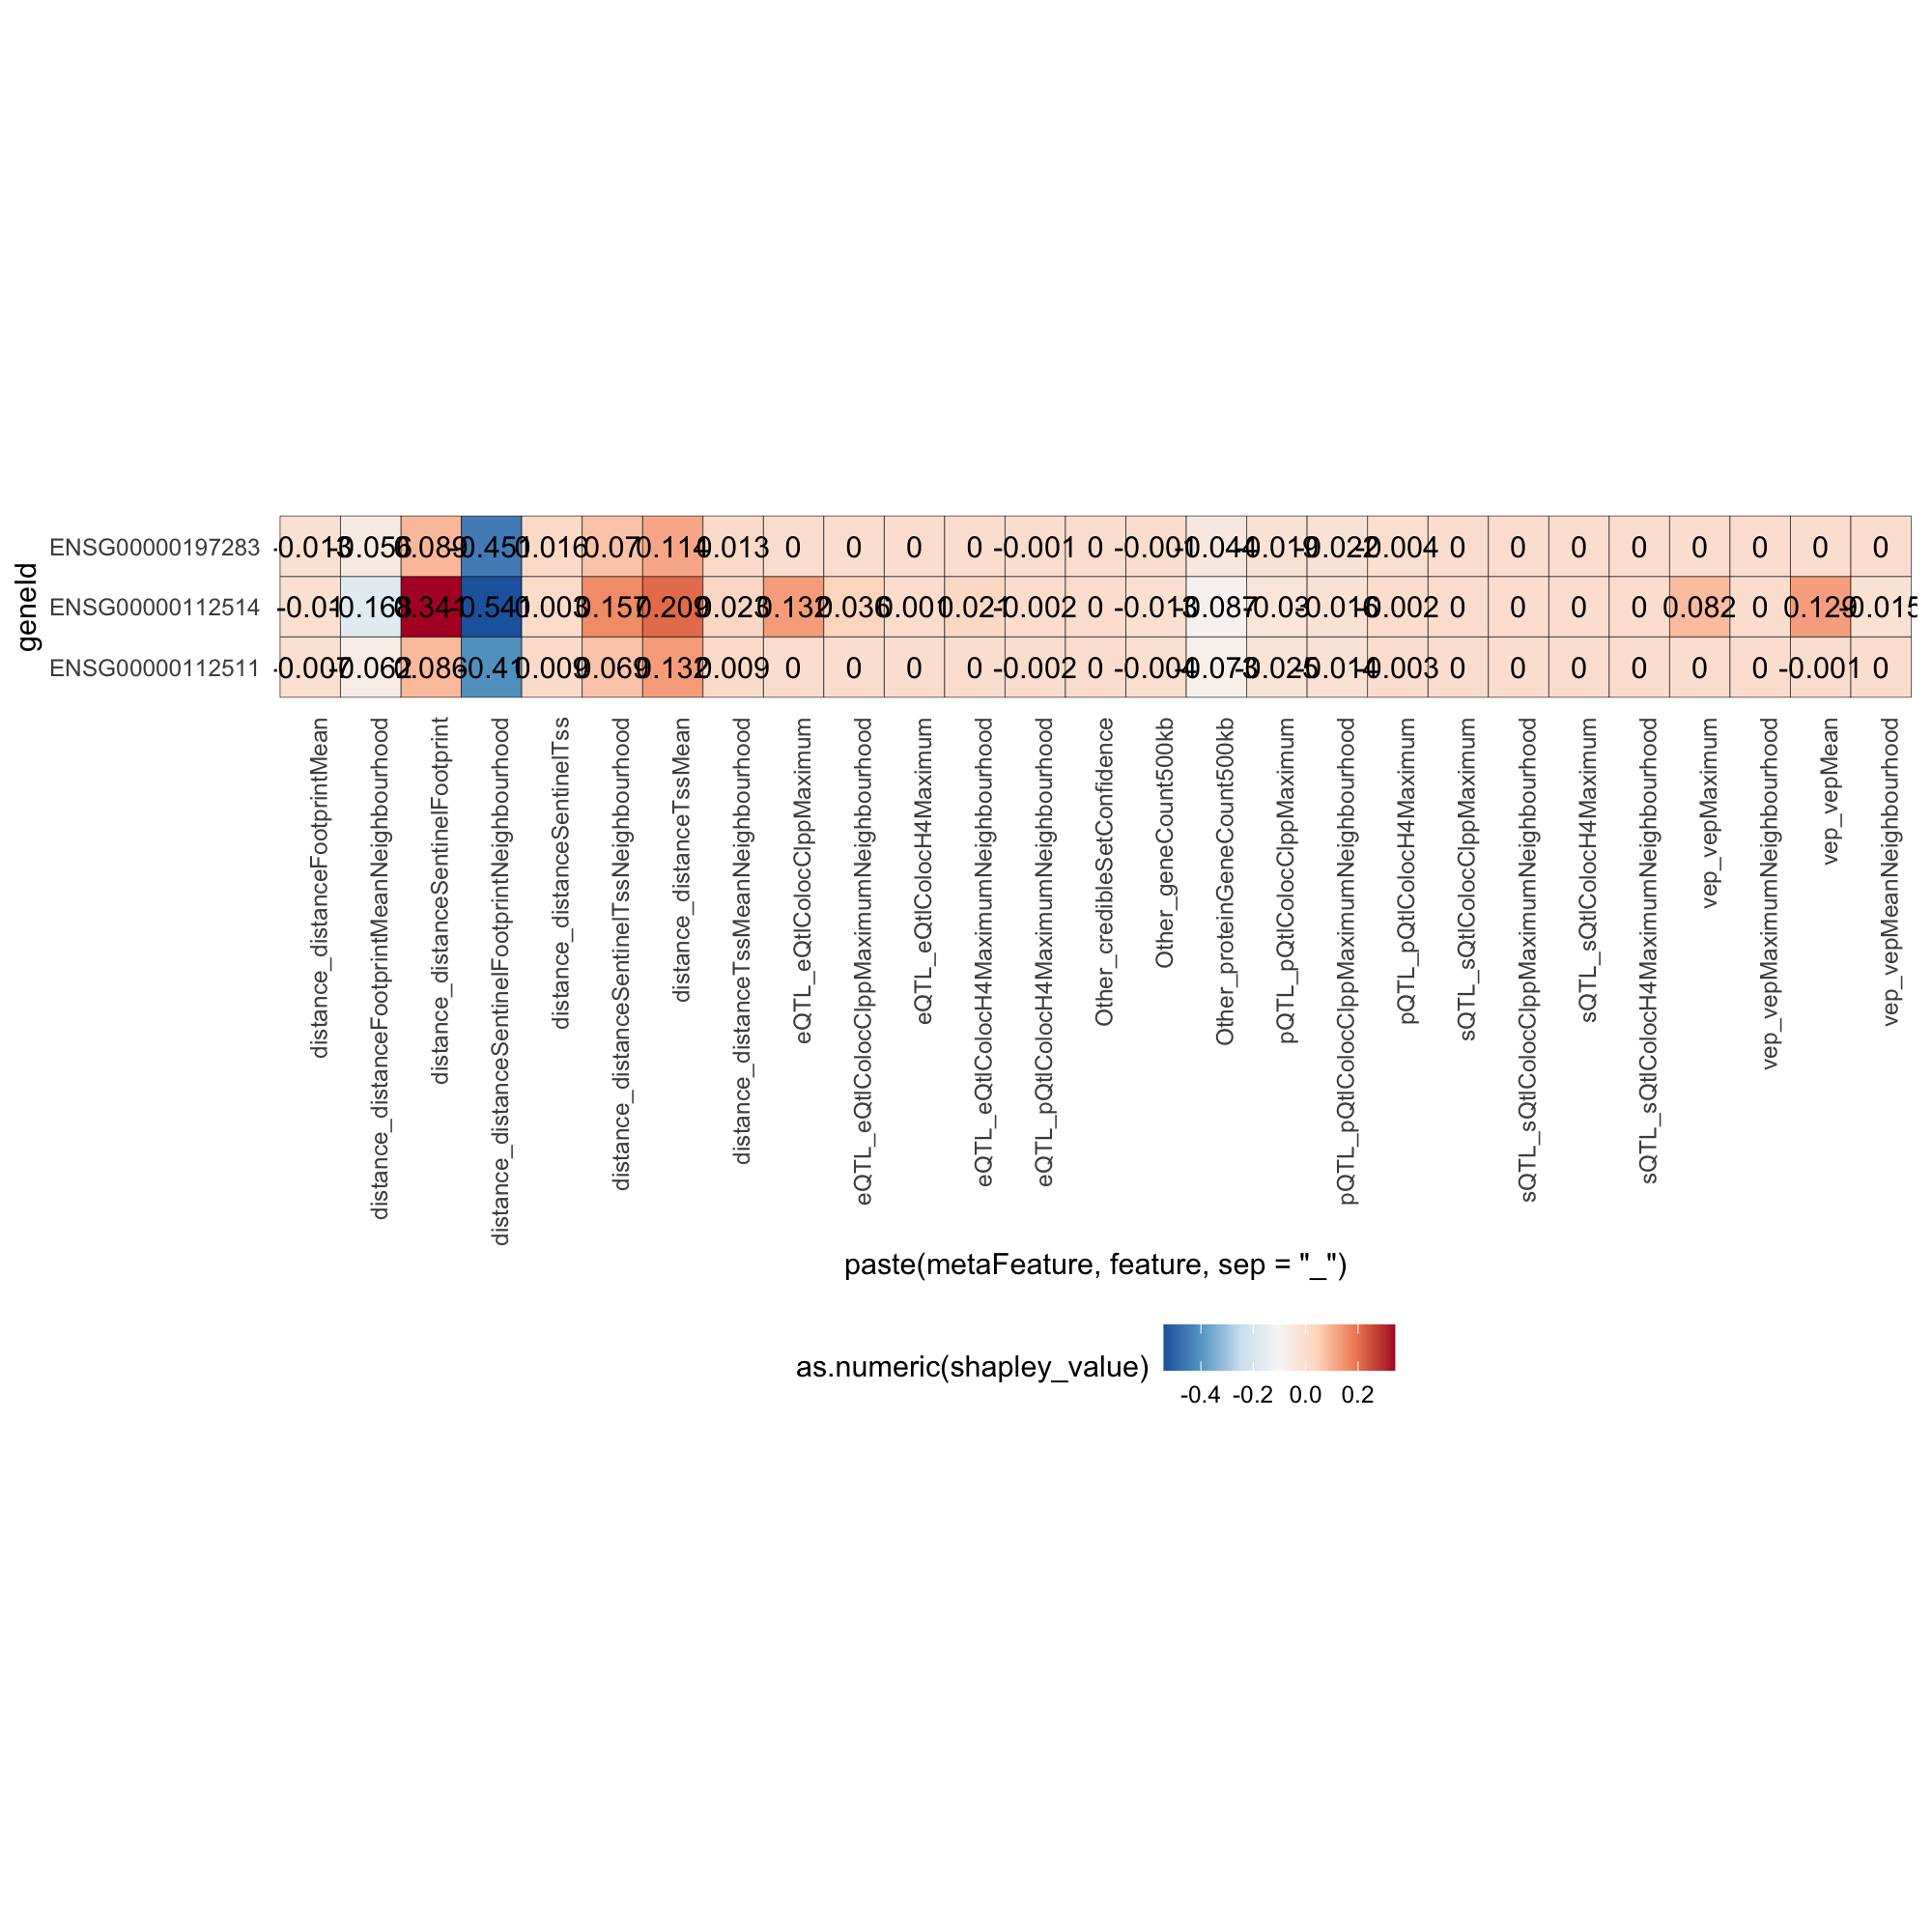

In [297]:
%%R -i shap_values_df_pd -w 10 -h 10 --units in -r 200

library(RColorBrewer)
ggplot(shap_values_df_pd_to_plot, aes(x = paste(metaFeature, feature, sep = "_"), y = geneId, fill = as.numeric(shapley_value), label=round(shapley_value, 3))) + 
geom_tile(color = "black") +
geom_text() +
scale_fill_distiller(palette = "RdBu") +
coord_equal() +
theme(
    panel.background = element_blank(), 
    axis.text.x = element_text(angle = 90, hjust = 1),
    axis.ticks = element_blank(),
    legend.position = "bottom",
)

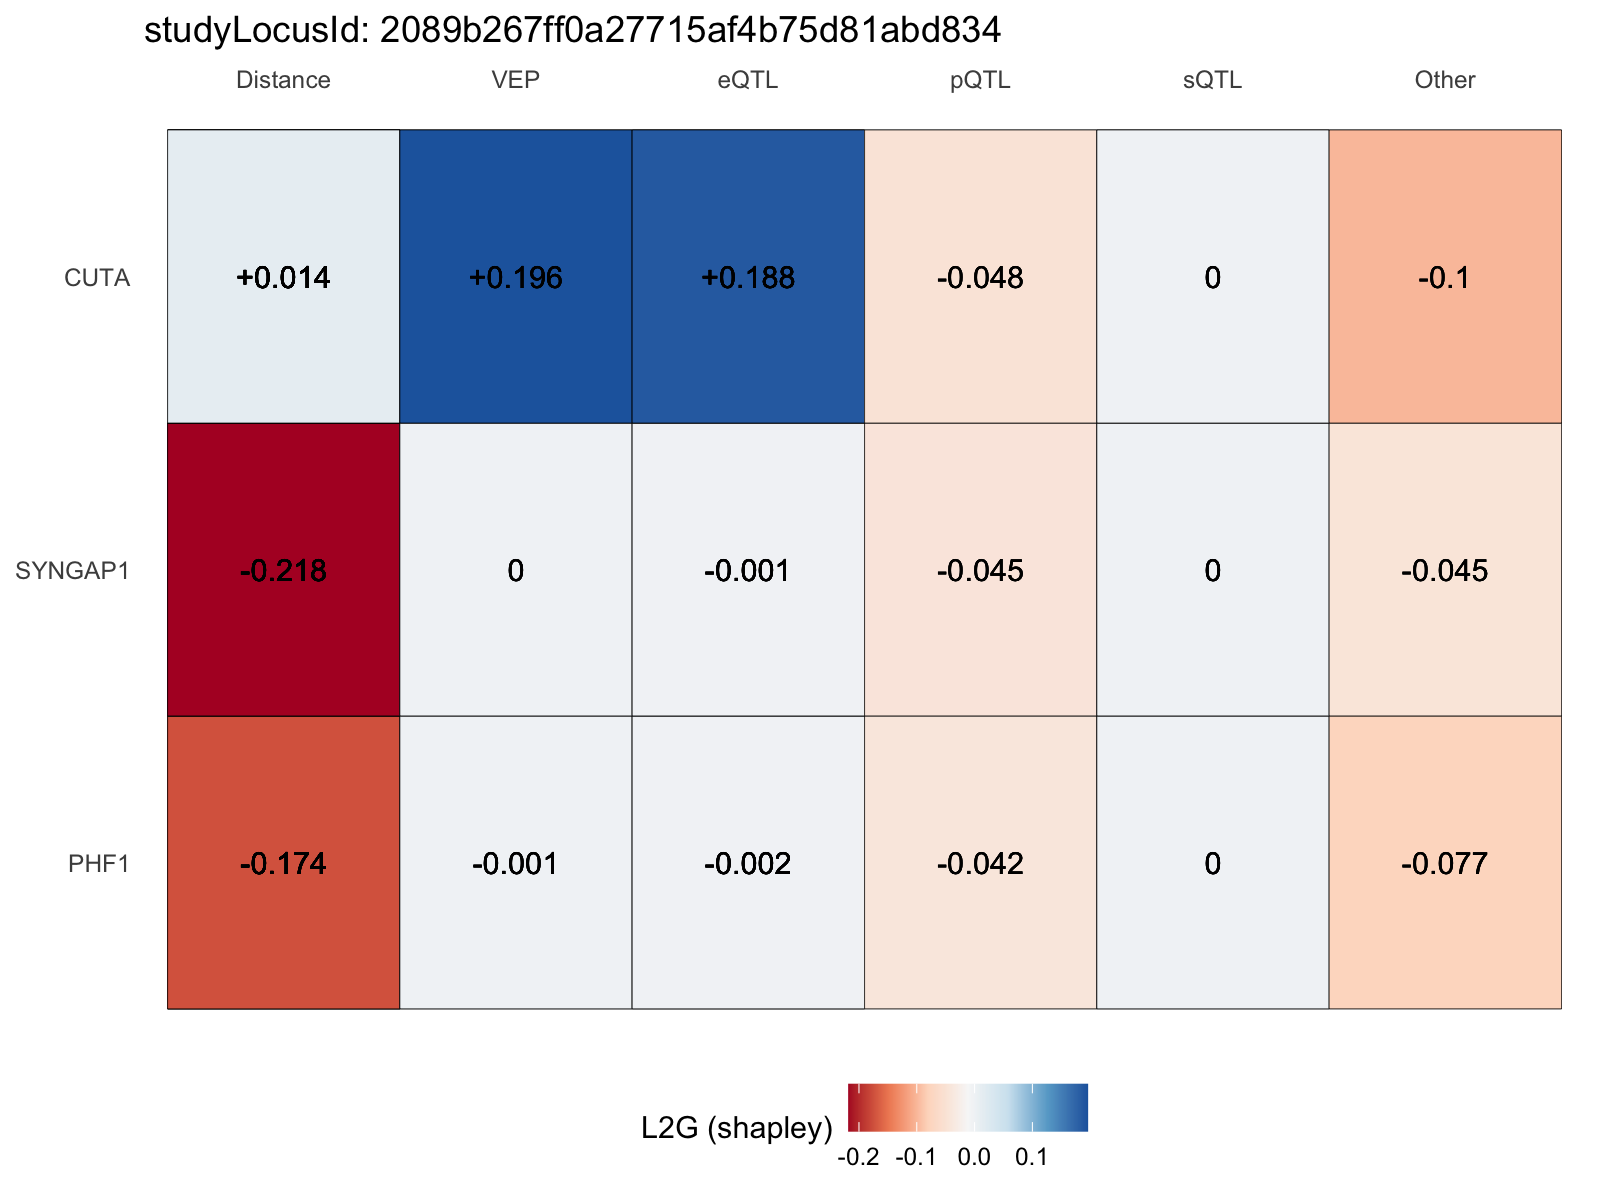

In [329]:
%%R -i shap_values_df_pd -w 8 -h 6 --units in -r 200

credible_set <- "2089b267ff0a27715af4b75d81abd834"
meta = c(
    "distanceSentinelFootprint" = "Distance",
    "distanceSentinelFootprintNeighbourhood" = "Distance",
    "distanceFootprintMean" = "Distance",
    "distanceFootprintMeanNeighbourhood" = "Distance",
    "distanceTssMean" = "Distance",
    "distanceTssMeanNeighbourhood" = "Distance",
    "distanceSentinelTss" = "Distance",
    "distanceSentinelTssNeighbourhood" = "Distance",
    "vepMaximum" = "VEP",
    "vepMaximumNeighbourhood" = "VEP",
    "vepMean" = "VEP",
    "vepMeanNeighbourhood" = "VEP",
    "eQtlColocClppMaximum" = "eQTL",
    "eQtlColocH4Maximum" = "eQTL",
    "eQtlColocClppMaximumNeighbourhood" = "eQTL",
    "eQtlColocH4MaximumNeighbourhood" = "eQTL",
    "pQtlColocH4MaximumNeighbourhood" = "eQTL",
    "pQtlColocClppMaximum" = "pQTL",
    "pQtlColocH4Maximum" = "pQTL",
    "pQtlColocClppMaximumNeighbourhood" = "pQTL",
    "sQtlColocClppMaximum" = "sQTL",
    "sQtlColocH4Maximum" = "sQTL",
    "sQtlColocClppMaximumNeighbourhood" = "sQTL",
    "sQtlColocH4MaximumNeighbourhood" = "sQTL",
    "geneCount500kb" = "Other",
    "proteinGeneCount500kb" = "Other",
    "credibleSetConfidence" = "Other"
)

grouped_shap_values_df_pd_to_plot <- shap_values_df_pd %>%
    mutate(metaFeature = fct_relevel(as.factor(meta[feature]), unique(as.character(meta)))) %>%
    mutate(geneId = fct_rev(fct_relevel(as.factor(geneId), "CUTA", "SYNGAP1", "PHF1"))) %>%
    group_by(geneId, metaFeature) %>%
    reframe(shapley_value = sum(shapley_value), base_value=base_value, L2G = L2G)
    
shapley_formatter <- function(x) {
    value <- round(x, 3)
    return(ifelse(value == 0, "0", ifelse(value > 0, paste("+", as.character(value), sep=""), paste("-", as.character(abs(value)), sep=""))))
}

p_metafeatures <- ggplot(grouped_shap_values_df_pd_to_plot, aes(x = metaFeature, y = geneId, fill = shapley_value, label=shapley_formatter(shapley_value))) + 
geom_tile(color = "black") +
geom_text() +
scale_fill_distiller(palette = "RdBu", direction=1, name = "L2G (shapley)") +
scale_x_discrete(position = "top") +
# coord_equal() +
theme(
    panel.background = element_blank(), 
    # axis.text.x = element_text(angle = 90, hjust = 1),
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "bottom",
) + ggtitle(paste("studyLocusId:", credible_set, sep = " "))
p_metafeatures

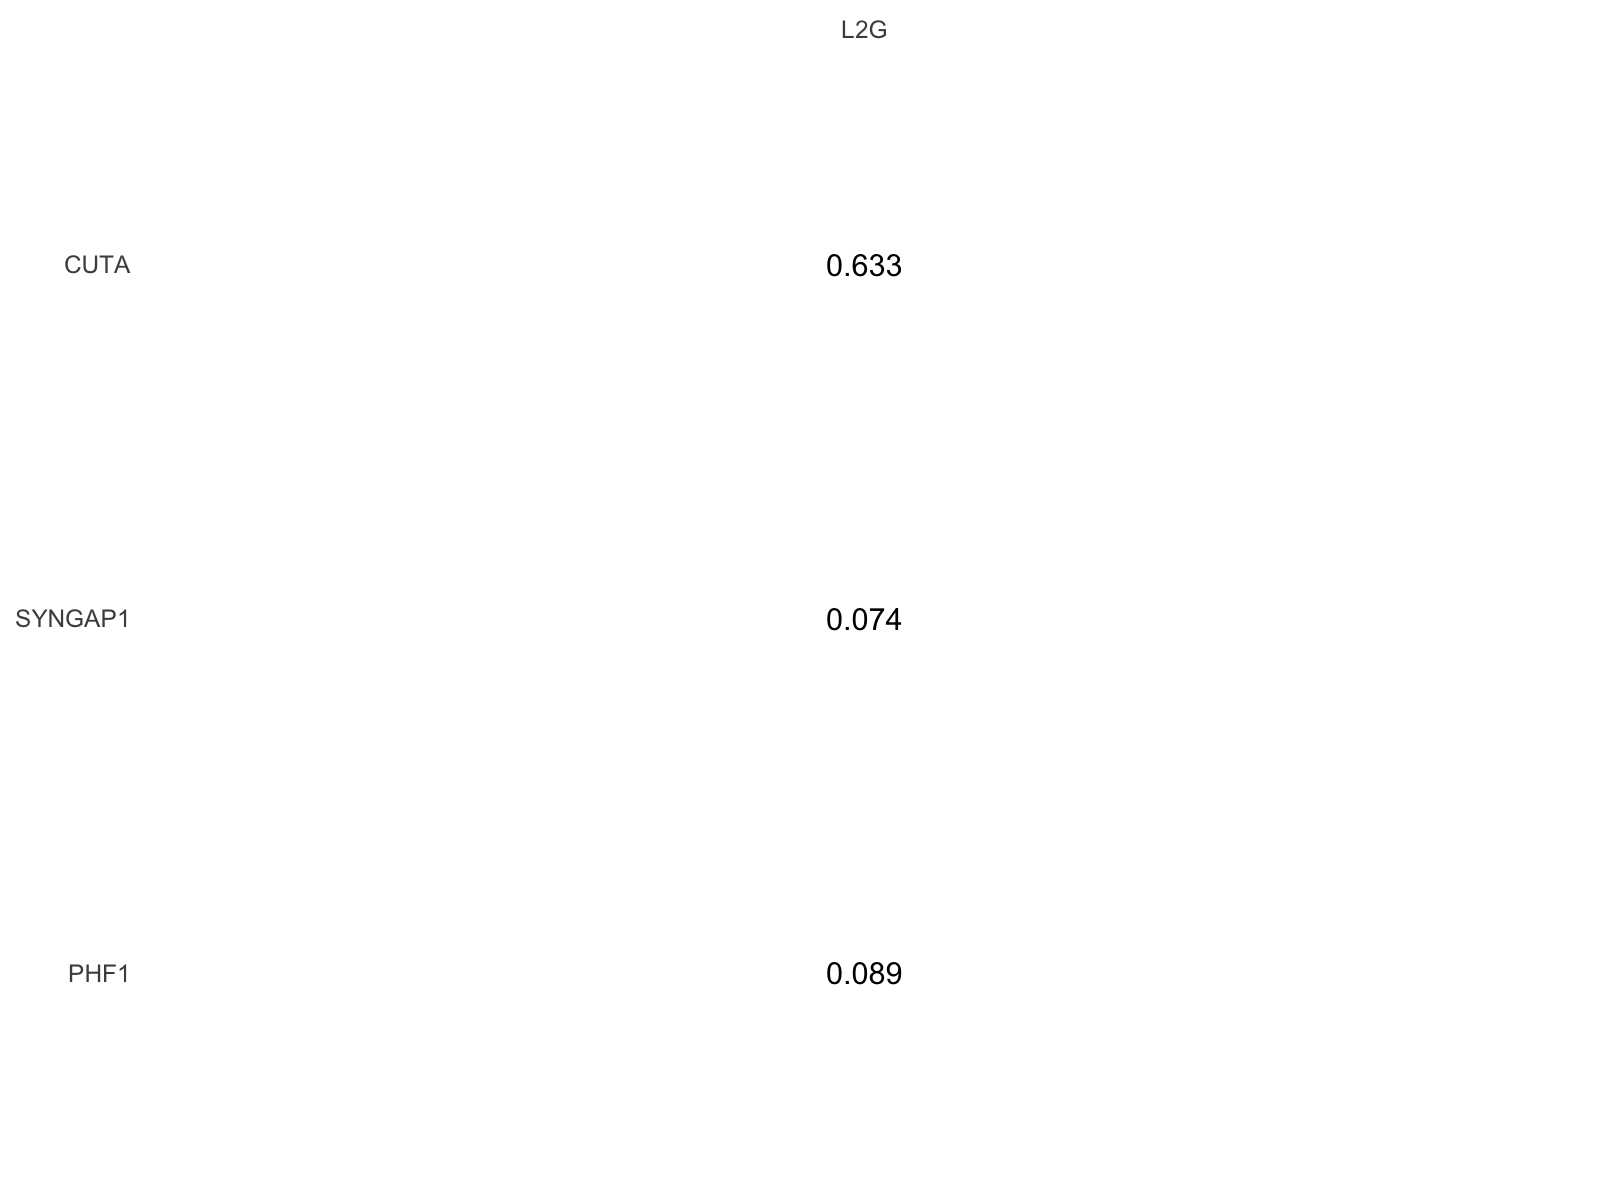

In [332]:
%%R -i shap_values_df_pd -w 8 -h 6 --units in -r 200

l2g_to_plot <- grouped_shap_values_df_pd_to_plot %>%
ungroup() %>%
select(geneId, L2G) %>%
distinct() %>%
pivot_longer(cols = c(L2G), names_to = "key", values_to = "value") %>%
mutate(key = fct_relevel(as.factor(key), "L2G"))

p_l2g <- ggplot(l2g_to_plot, aes(x = key, y = geneId, label = round(value, 3))) +
geom_tile(fill="white") +
geom_text() +
# coord_equal() +
scale_x_discrete(position = "top") +
theme(
    panel.background = element_blank(), 
    # axis.text.x = element_text(angle = 90, hjust = 1),
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "bottom",
)
p_l2g


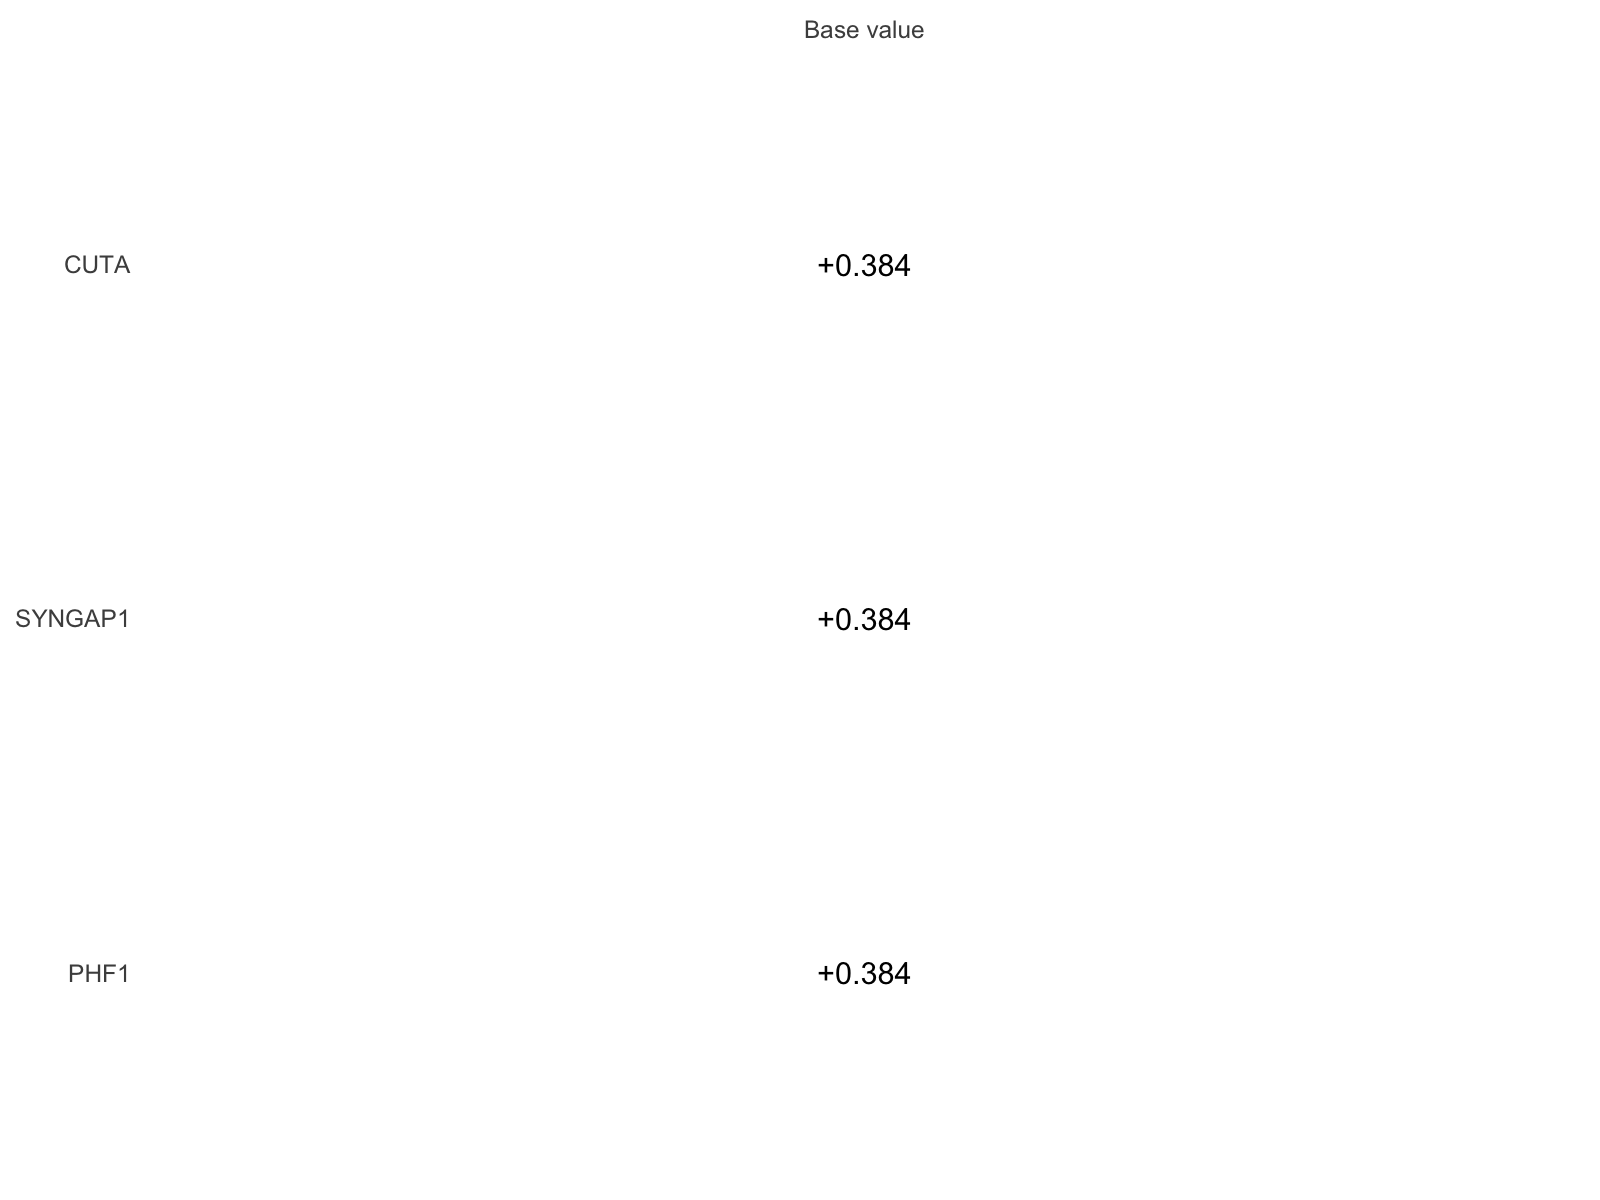

In [331]:
%%R -i shap_values_df_pd -w 8 -h 6 --units in -r 200

base_value_to_plot <- grouped_shap_values_df_pd_to_plot %>%
ungroup() %>%
select(geneId, base_value) %>%
distinct() %>%
pivot_longer(cols = c(base_value), names_to = "key", values_to = "value") %>%
mutate(key = fct_recode(as.factor(key), "Base value"="base_value"))

p_base_value <- ggplot(base_value_to_plot, aes(x = key, y = geneId, label = paste("+", round(value, 3), sep = ""))) +
geom_tile(fill="white") +
geom_text() +
# coord_equal() +
scale_x_discrete(position = "top") +
theme(
    panel.background = element_blank(), 
    # axis.text.x = element_text(angle = 90, hjust = 1),
    axis.title = element_blank(),
    axis.ticks = element_blank(),
    legend.position = "bottom",
)
p_base_value


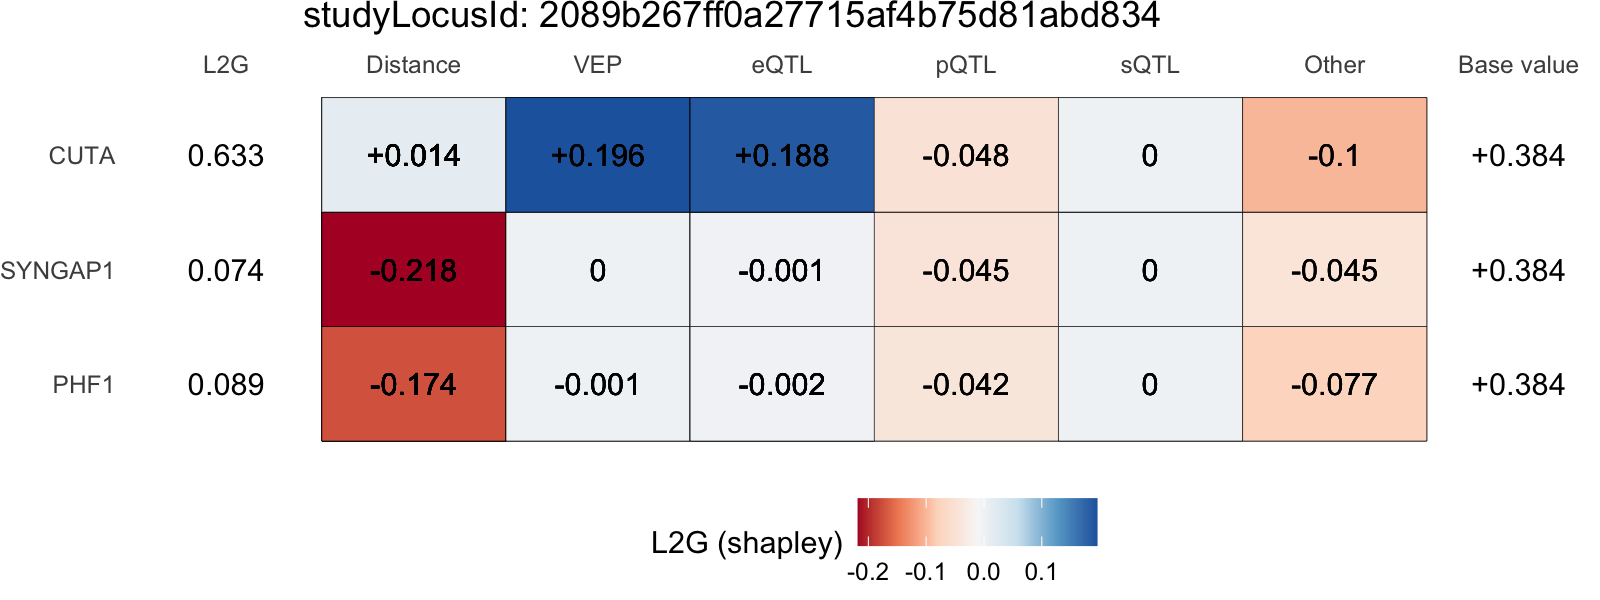

In [336]:
%%R -w 8 -h 3 --units in -r 200

library(cowplot)
plot_grid(p_l2g + theme(plot.margin=unit(c(0,-5,0,0), unit = "pt")),
          p_metafeatures + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), plot.margin=unit(c(0,0,0,-5), unit = "pt")),
          p_base_value + theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), plot.margin=unit(c(0,5.5,0,0), unit = "pt")),
          align = "h",
          axis = "bt",
          nrow = 1,
          rel_widths = c(0.6, 2.2, 0.3))